# Mesh plotter - visualizations

This notebook contains code for visualizing neurons, connections and any XYZ dots in neuropil volums

## A) Loading data and pre-analysis

In [2]:
#Importing packages
import navis
import fafbseg
from fafbseg import flywire
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
import os
import math 
from caveclient import CAVEclient
client = CAVEclient('flywire_fafb_production')

#%% Plots settings
font = {'family' : 'arial',
        'weight' : 'normal',
        'size'   : 12}
axes = {'labelsize': 8, 'titlesize': 8}
ticks = {'labelsize': 4}
legend = {'fontsize': 8}
plt.rc('font', **font)
plt.rc('axes', **axes)
plt.rc('xtick', **ticks)
plt.rc('ytick', **ticks)

cm = 1/2.54  # centimeters in inches
save_figures = True



In [4]:
############################################# USER INFORMATION ################################################
###############################################################################################################
#General analysis information (user defined)


#Count coverage
desired_coverage = 80 # in percent
plus_minus = 5 # in percent

#Synaptic counts
desired_count = 3 # minimun number of synapses to consider in the analysis
syn_thr_min = 1 # minimun number of synaptic contacts to be considered as relevant for the analysis
num_type_copies_min = 2 #Number for neuron copies relevant for the low-synapses partners

#Neuron counts
desired_quantile = 0.8 # selected quantile for neuron counts

#Main presynaptic partner
last_input_neuron = 1000 # last input to be considered in summary dataframes across columns

#Data set 
dataset_name = 'FAFB'
neuron_of_interest = 'Tm9' 
instance_id_column = 'optic_lobe_id' # 'optic_lobe_id', 'column_id'

#Path and file
dataPath =  r'D:\Connectomics-Data\FlyWire\Excels\drive-data-sets'
fileDate = '20230615'
fileName = f'Tm9_neurons_input_count_ME_L_{fileDate}.xlsx'
fileName_database = f'Tm9 proofreadings_{fileDate}.xlsx'

In [5]:
#%% 
################################################## PRE-ANALYSIS ###############################################
###############################################################################################################

#Loading FAFB data from our data base (excel file)
filePath = os.path.join(dataPath,fileName)
df = pd.read_excel(filePath)

#Loading FAFB data from our data base (excel file)
filePath = os.path.join(dataPath,fileName_database)
database_df = pd.read_excel(filePath)

#Dropping rows:
if df["postsynaptic_ID"][0] == 'asdf': #Dropping the fisrt row ('asdf' was added as a walk-around to set that column values as type str)
    df = df.iloc[1: , :]
    df.reset_index(inplace=True,drop=True)

if database_df["seg_id"][0] == 'asdf': #Dropping the fisrt row ('asdf' was added as a walk-around to set that column values as type str)
    database_df = database_df.iloc[1: , :]
    database_df.reset_index(inplace=True,drop=True)

if 'INPUTS PROOFREAD' in df.values: # Removing unnecessary rows ment for human use only
    df = df[df['presynaptic_ID']!= 'INPUTS PROOFREAD'].copy() # Getting rid of info rows with no connectomics data

if 'N.I.' in df.values: # Removing non identified (N.I.) inputs
    df = df[df['symbol']!= 'N.I.'].copy() # Getting rid of info rows with no connectomics data

#Adjusting column names to meet the naming of the FIB25 data sets (interesting for future use or comparison)
#Creating new columns
df['instance_pre'] = df['symbol'] + '::' + df[instance_id_column]
df['instance_post'] = neuron_of_interest + '::' + df[instance_id_column]
df['type_post'] = neuron_of_interest
df['counts']= df['counts'].astype(int)
#Sorting rows based on count synapse number
df = df.groupby(['instance_post']).apply(lambda x: x.sort_values(['counts'], ascending = False)).reset_index(drop=True)
#Ranking the neurons
df['rank'] = df.groupby(['instance_post']).cumcount().tolist()
#Renaming columns
df.rename(columns={'presynaptic_ID':'bodyId_pre', 'counts':'W', 'postsynaptic_ID':'bodyId_post','symbol':'type_pre'}, inplace = True)
#Keeping only columns of interest
cols_to_keep = ['rank','patch_id','column_id','optic_lobe_id','detached_lamina (Y/N)','healthy_L3 (Y/N)','instance_pre','type_pre','bodyId_pre','instance_post','type_post','bodyId_post','W']
df = df[cols_to_keep].copy()
#Filtering out faulty data
df = df[df['detached_lamina (Y/N)'] == 'N'].copy() #Keep only the columns below a healthy lamina
df = df[df['healthy_L3 (Y/N)'] != 'N'].copy() #Discard the onces with clear unhealthy L3

#Calculating relative counts (weigths)
df['column_percent'] = round((df['W'] / df.groupby('instance_post')['W'].transform('sum'))*100,2)
df['cumulative_column_percent'] = df.groupby('instance_post')['column_percent'].cumsum()

#Printing useful information
id_column = df[instance_id_column].unique().tolist()
print(f'The following column ids (n={len(id_column)}) are part of the analysis: \n {id_column}')


desired_count_df = df[df['W']== desired_count].copy()
last_percent_with_desired_count = pd.DataFrame(desired_count_df.groupby(['instance_post'])['cumulative_column_percent'].max()) #Covarage across columns per the desired_count
print(last_percent_with_desired_count)
print(f'Coverage (%) for syn >= {desired_count}')
print(f"The desired {desired_count} have a desired % coverage average across columns = {round(last_percent_with_desired_count['cumulative_column_percent'].mean(),2)}: ")

The following column ids (n=129) are part of the analysis: 
 ['L100', 'L105', 'L112', 'L115', 'L118', 'L120', 'L129', 'L130', 'L131', 'L132', 'L139', 'L140', 'L148', 'L15', 'L150', 'L151', 'L152', 'L157', 'L16', 'L164', 'L17', 'L170', 'L174', 'L178', 'L181', 'L182', 'L184', 'L185', 'L19', 'L191', 'L199', 'L207', 'L21', 'L210', 'L216', 'L24', 'L251', 'L258', 'L26', 'L263', 'L267', 'L270', 'L28', 'L29', 'L297', 'L30', 'L31', 'L32', 'L329', 'L33', 'L336', 'L34', 'L345', 'L347', 'L35', 'L351', 'L353', 'L358', 'L36', 'L360', 'L361', 'L365', 'L37', 'L370', 'L371', 'L386', 'L394', 'L398', 'L402', 'L406', 'L407', 'L409', 'L419', 'L42', 'L456', 'L46', 'L48', 'L49', 'L492', 'L503', 'L53', 'L530', 'L531', 'L547', 'L549', 'L55', 'L552', 'L559', 'L567', 'L586', 'L59', 'L590', 'L591', 'L592', 'L593', 'L606', 'L607', 'L61', 'L624', 'L627', 'L628', 'L637', 'L64', 'L644', 'L646', 'L647', 'L657', 'L658', 'L659', 'L66', 'L665', 'L668', 'L67', 'L676', 'L680', 'L682', 'L683', 'L69', 'L71', 'L73', 'L77', 'L

## B) Plotting meshes and XYZ coordinates

In [6]:
#Getting the neuron´s meshes
root_ids = df['bodyId_post'].unique().tolist()
m_all = flywire.get_mesh_neuron(root_ids)
print('- Got all neuron meshes -')

Fetching:   0%|          | 0/129 [00:00<?, ?it/s]

- Got all neuron meshes -


In [22]:
#Gettting the center point in specific neuropile from database
xyz_neuropil = 'XYZ-ME'
xyz_df = database_df[database_df['seg_id'].isin(root_ids)].copy()
xyz_pre = xyz_df[xyz_neuropil].tolist()
# Split each string by comma and convert the elements to floats
xyz_pre_arr = np.array([list(map(float, s.split(','))) for s in xyz_pre])

In [9]:
# Plotting
fig = navis.plot3d([m_all, xyz_pre_arr], backend='k3d', 
                   scatter_kws ={"color":'green', "size":20})

Output()

In [12]:
plt.show(fig)

In [13]:
navis.plot3d([m_all, xyz_pre_arr], backend='k3d', 
                   scatter_kws ={"color":'green', "size":20})

Output()

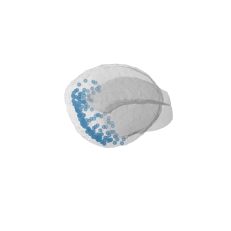

In [34]:
OL_R = flywire.get_neuropil_volumes(['ME_R','LO_R','LOP_R']) # ['LOP_L', 'LOP_R'], ['LO_R'], ['ME_R']
xyz_pre_arr_new = xyz_pre_arr * np.array([4, 4, 40])

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.scatter(xyz_pre_arr_new[:, 0], xyz_pre_arr_new[:, 1], xyz_pre_arr_new[:, 2], s=10)  # Adjust the size (s) as desired

navis.plot2d([OL_R], method='3d_complex', ax=ax)

plt.show()